## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

## Read CSV Files

In [2]:
total = pd.read_csv('./total_data_plos_only_cleaned.csv')
total.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,doi,year,month,day,volume,issue,journal,title,text,abstract,keywords,retraction_binary,unpacked_keywords,clean_text,clean_text_lem
0,0,0,0,10.1208/s12249-016-0596-x,2016.0,8.0,10.0,18.0,5.0,AAPS PharmSciTech,Study of the Transformations of Micro/Nano-cry...,‘Polymorphism’ generally referred as the abili...,This study elucidates the physical properties ...,"['monoclinic', 'nano-sized crystals', 'orthorh...",1,"['monoclinic', 'nano-sized', 'crystals', 'orth...",Polymorphism generally referred as the ability...,Polymorphism generally referred a the ability ...
1,1,1,1,10.1021/acscentsci.9b00224,2019.0,5.0,9.0,5.0,6.0,ACS central science,Targeted Protein Internalization and Degradati...,Traditional\ndrug development efforts are focu...,Targeted,[],1,[],Traditional drug development efforts are focus...,Traditional drug development effort are focuse...
2,2,2,2,10.1021/acsomega.8b00488,2018.0,6.0,27.0,3.0,6.0,ACS omega,Regulating the Microstructure of Intumescent F...,Intumescent flame retardants\nare now being us...,A compatibilizer,[],1,[],Intumescent flame retardants are now being use...,Intumescent flame retardant are now being used...
3,3,3,3,10.1021/acsomega.8b00153,2018.0,6.0,25.0,3.0,6.0,ACS omega,Solid-to-Solid Crystallization of Organic Thin...,Crystal growth process is basic and essential ...,The solid-to-solid crystallization processes o...,[],1,[],Crystal growth process is basic and essential ...,Crystal growth process is basic and essential ...
4,4,4,4,10.1107/S1600536811022574,2011.0,6.0,18.0,67.0,NaN,"Acta crystallographica. Section E, Structure r...",Oxonium picrate.,For general background to organic salts of pic...,"The title compound, H3O+·C6H2N3O7",[],1,[],For general background to organic salts of pic...,For general background to organic salt of picr...


In [3]:
total = total.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [4]:
total.columns

Index(['doi', 'year', 'month', 'day', 'volume', 'issue', 'journal', 'title',
       'text', 'abstract', 'keywords', 'retraction_binary',
       'unpacked_keywords', 'clean_text', 'clean_text_lem'],
      dtype='object')

In [5]:
no_retract = pd.read_csv('./no_retraction_data_plos_only_cleaned.csv')
no_retract = no_retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [6]:
retract = pd.read_csv('./retraction_data_plos_only_cleaned.csv')
retract = retract.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])

In [7]:
total['year'] = total['year'].astype(str)
total['month'] = total['month'].astype(str)
total['day'] = total['day'].astype(str)
total['volume'] = total['volume'].astype(str)
total['issue'] = total['issue'].astype(str)

retract['year'] = retract['year'].astype(float)
retract['month'] = retract['month'].astype(float)
retract['day'] = retract['day'].astype(float)
retract['volume'] = retract['volume'].astype(float)
retract['issue'] = retract['issue'].astype(float)

no_retract['year'] = no_retract['year'].astype(float)
no_retract['month'] = no_retract['month'].astype(float)
no_retract['day'] = no_retract['day'].astype(float)
no_retract['volume'] = no_retract['volume'].astype(float)
no_retract['issue'] = no_retract['issue'].astype(float)

In [8]:
total.loc[total['abstract'].isnull()==True].index

Int64Index([   45,   183,   186,   217,   286,   346,   462,   698,   744,
              783,
            ...
             9723,  9801,  9822, 10022, 10024, 10146, 10301, 10355, 10357,
            10372],
           dtype='int64', length=115)

In [9]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10619 entries, 0 to 10618
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   doi                10619 non-null  object
 1   year               10619 non-null  object
 2   month              10619 non-null  object
 3   day                10619 non-null  object
 4   volume             10619 non-null  object
 5   issue              10619 non-null  object
 6   journal            10619 non-null  object
 7   title              10619 non-null  object
 8   text               10619 non-null  object
 9   abstract           10504 non-null  object
 10  keywords           10619 non-null  object
 11  retraction_binary  10619 non-null  int64 
 12  unpacked_keywords  1537 non-null   object
 13  clean_text         10619 non-null  object
 14  clean_text_lem     10619 non-null  object
dtypes: int64(1), object(14)
memory usage: 1.2+ MB


## Feature Engineering

### Keywords

#### Retraction

In [10]:
#https://stackoverflow.com/questions/40950791/remove-quotes-from-string-in-python
keywords_list = []
count = 0
for i in retract['keywords']:
    if i == []:
        pass
    else:
        for j in i.split():
            keywords_list.append(j.replace("'",'').replace('[','').replace(',','').replace(']','').replace('(','').replace(')','').replace('\\n', '').replace('\\n','').lower())

In [11]:
#cells -> cell
lemmatizer = WordNetLemmatizer()
ls_keywords = []
for i in keywords_list:
    ls_keywords.append(lemmatizer.lemmatize(i))
pd.Series(ls_keywords).value_counts().head(11)

            663
cell        186
antibody    116
cancer      112
response     89
disease      84
health       79
factor       71
theory       67
gene         66
heat         61
dtype: int64

#### No Retraction

In [12]:
no_retract['keywords'].value_counts()

[]                                                                            9081
['Socioeconomic inequality', 'Antenatal care', 'Decomposition', 'Nigeria']       1
Name: keywords, dtype: int64

#### Keywords Binary

In [13]:
keywords_binary = []
for i in total['keywords']:
    if len(i) != 2:
        keywords_binary.append(1)
    else:
        keywords_binary.append(0)
print(len(keywords_binary))

10619


In [14]:
total['keywords_binary'] = keywords_binary

In [15]:
keywords_binary = []
for i in retract['keywords']:
    if len(i) != 2:
        keywords_binary.append(1)
    else:
        keywords_binary.append(0)
print(len(keywords_binary))

retract['keywords_binary'] = keywords_binary

1537


### Word Count

In [16]:
list_words = []
for i in range(0, len(total['clean_text'])):
    list_words.append(len(total['clean_text'][i].split()))
total['num_words'] = list_words 

### Character Length

In [17]:
list_words = []
for i in range(0, len(total['clean_text'])):
    list_words.append(len(total['clean_text'][i]))
total['character_length'] = list_words 

### Animal Studies

In [18]:
total.shape

(10619, 18)

In [19]:
animal_terms = ['IACUC', 'mouse', 'mice', 'rats', 'rat', 'hamster', 'hamsters', 'pigs', 'rabbits', 'rabbit', 
                'cat', 'cats', 'dog', 'dogs', 'ungulate', 'ungulates', 'pig', 'horse', 'donkey', 'goat',
               'bovine', 'porcine', 'murine', 'chicken', 'sheep', 'cow', 'cows', 'horses', 'goats']

#http://vetmed.tamu.edu/media/2005639/vadnais%20protein%20therapeutics%202017.pdf
#https://www.ncbi.nlm.nih.gov/books/NBK218261/

In [20]:
def animal_binary(dataframe):
    list_articles = []
    iacuc = []
    for i in range(0, len(dataframe['clean_text'])):
        count = 0
        for j in dataframe['clean_text'][i].split():
            for k in animal_terms:
                if j == k:
                    if i not in list_articles:
                        list_articles.append(i)
                        iacuc.append(1)
                        count = 1
                else:
                    pass
        if count == 0:
            iacuc.append(0)
        else:
            pass
                   
    print(len(list_articles))
    print(len(iacuc))

    dataframe['animal_binary'] = iacuc
    return

In [21]:
animal_binary(total)
animal_binary(retract)
animal_binary(no_retract)

4289
10619
791
1537
3498
9082


In [22]:
def list_of_animal_words(dataframe):
    list_articles = []
    list_words = []
    for i in range(0, len(dataframe['clean_text'])):
        count = 0
        iacuc = []
        for j in dataframe['clean_text'][i].split():
            for k in animal_terms:
                if j == k:
                    if i not in list_articles:
                        list_articles.append(i)
                    if j not in iacuc:
                        iacuc.append(k)
                    count = 1
                else:
                    pass
        if count == 0:
            list_words.append([])
        else:
            list_words.append(iacuc)
                    
    print(len(list_articles))
    print(len(list_words))
    dataframe['animal_words'] = list_words
    return

In [23]:
list_of_animal_words(total)
list_of_animal_words(retract)
list_of_animal_words(no_retract)

4289
10619
791
1537
3498
9082


In [24]:
def animal_dummy(word_list, column_name, dataframe):
    column_list = []
    for i in dataframe['animal_words']:
        count = 0
        for j in i:
            for k in word_list:
                if j == k:
                    count = 1
        column_list.append(count)
    
    dataframe[column_name] = column_list
    return 

In [25]:
iacuc = ['IACUC']
mouse = ['mouse', 'mice']
rat = ['rat', 'rats']
murine = ['murine']
hamster = ['hamster', 'hamsters']
rabbit = ['rabbit', 'rabbits']
cat = ['cat', 'cats']
pig = ['pig', 'pigs', 'porcine']
dog = ['dog', 'dogs']
ungulate = ['ungulate', 'ungulates']
horse = ['horse', 'horses']
donkey = ['donkey']
goat = ['goat', 'goats']
cow = ['cow', 'cows', 'bovine']
chicken = ['chicken']
sheep = ['sheep']

In [26]:
animal_dummy(iacuc, 'iacuc', retract)
animal_dummy(mouse, 'mouse', retract)
animal_dummy(rat, 'rat', retract)
animal_dummy(murine, 'murine', retract)
animal_dummy(hamster, 'hamster', retract)
animal_dummy(rabbit, 'rabbit', retract)
animal_dummy(cat, 'cat', retract)
animal_dummy(pig, 'pig', retract)
animal_dummy(dog, 'dog', retract)
animal_dummy(ungulate, 'ungulate', retract)
animal_dummy(horse, 'horse', retract)
animal_dummy(donkey, 'donkey', retract)
animal_dummy(goat, 'goat', retract)
animal_dummy(cow, 'cow', retract)
animal_dummy(chicken, 'chicken', retract)
animal_dummy(sheep, 'sheep', retract)

animal_dummy(iacuc, 'iacuc', no_retract)
animal_dummy(mouse, 'mouse', no_retract)
animal_dummy(rat, 'rat', no_retract)
animal_dummy(murine, 'murine', no_retract)
animal_dummy(hamster, 'hamster', no_retract)
animal_dummy(rabbit, 'rabbit', no_retract)
animal_dummy(cat, 'cat', no_retract)
animal_dummy(pig, 'pig', no_retract)
animal_dummy(dog, 'dog', no_retract)
animal_dummy(ungulate, 'ungulate', no_retract)
animal_dummy(horse, 'horse', no_retract)
animal_dummy(donkey, 'donkey', no_retract)
animal_dummy(goat, 'goat', no_retract)
animal_dummy(cow, 'cow', no_retract)
animal_dummy(chicken, 'chicken', no_retract)
animal_dummy(sheep, 'sheep', no_retract)

animal_dummy(iacuc, 'iacuc', total)
animal_dummy(mouse, 'mouse', total)
animal_dummy(rat, 'rat', total)
animal_dummy(murine, 'murine', total)
animal_dummy(hamster, 'hamster', total)
animal_dummy(rabbit, 'rabbit', total)
animal_dummy(cat, 'cat', total)
animal_dummy(pig, 'pig', total)
animal_dummy(dog, 'dog', total)
animal_dummy(ungulate, 'ungulate', total)
animal_dummy(horse, 'horse', total)
animal_dummy(donkey, 'donkey', total)
animal_dummy(goat, 'goat', total)
animal_dummy(cow, 'cow', total)
animal_dummy(chicken, 'chicken', total)
animal_dummy(sheep, 'sheep', total)

In [27]:
total['animal_binary'][:1537].value_counts(normalize=True)

1    0.514639
0    0.485361
Name: animal_binary, dtype: float64

In [28]:
total['animal_binary'][1537:].value_counts(normalize=True)

0    0.614843
1    0.385157
Name: animal_binary, dtype: float64

### Human Studies

In [29]:
total.shape

(10619, 36)

In [30]:
list_articles = []
irb = []
for i in range(0, len(total['clean_text'])):
    count = 0
    word_count = 0
    patient_count = 0
    for j in total['clean_text'][i].split():
        if j == 'IRB' or j == 'case' or j == 'participants':
            if j =='IRB' or j == 'participants':
                if i not in list_articles:
                    list_articles.append(i)
                    irb.append(1)
                    count = 1
            else:
                try:
                    if total['clean_text'][i].split()[word_count+1] == 'study':
                        if i not in list_articles:
                            list_articles.append(i)
                            irb.append(1)
                            count = 1
                    else:
                        pass
                except:
                    pass            
        else:
            pass
        word_count += 1
    if count == 0:
        irb.append(0)
    else:
        pass
                  
print(len(list_articles))
print(len(irb))
total['irb_binary'] = irb

3214
10619


In [31]:
total['irb_binary'][:1537].value_counts(normalize=True)

0    0.829538
1    0.170462
Name: irb_binary, dtype: float64

In [32]:
total['irb_binary'][1537:].value_counts(normalize=True)

0    0.674961
1    0.325039
Name: irb_binary, dtype: float64

### Regulatory Binary

In [33]:
regulatory = []
for i in range(0, len(total['irb_binary'])):
    if total['irb_binary'][i] == 1 or total['animal_binary'][i] == 1:
        if total['irb_binary'][i] == 1 and total['animal_binary'][i] == 1:
            regulatory.append(2)
        else:
            regulatory.append(1)
    else:
        regulatory.append(0)
len(regulatory)

10619

In [34]:
total['reg_binary'] = regulatory
total = total.rename(columns={'reg_binary':'regulatory'})
total['regulatory'][:1537].value_counts(normalize=True)

1    0.545869
0    0.384515
2    0.069616
Name: regulatory, dtype: float64

In [35]:
total['regulatory'][1537:].value_counts(normalize=True)

1    0.581150
0    0.354327
2    0.064523
Name: regulatory, dtype: float64

### Review Binary

In [36]:
list_articles = []
review = []
for i in range(0, len(total['clean_text'])):
    count = 0
    word_count = 0
    for j in total['clean_text'][i].split():
        if j == 'review':
            if total['clean_text'][i].split()[word_count-1] == 'this':
                if i not in list_articles:
                    list_articles.append(i)
                    review.append(1)
                    count = 1
        else:
            pass
        word_count += 1
    if count == 0:
        review.append(0)
    else:
        pass
                  
print(len(list_articles))
print(len(review))

total['review_binary'] = review

234
10619


In [37]:
total['review_binary'][:1537].value_counts(normalize=True)

0    0.960963
1    0.039037
Name: review_binary, dtype: float64

In [38]:
total['review_binary'][1537:].value_counts(normalize=True)

0    0.980841
1    0.019159
Name: review_binary, dtype: float64

### Novel Ideas

In [39]:
list_articles = []
novel_idea = []
for i in range(0, len(total['clean_text'])):
    count = 0
    novel_count = 0
    for j in total['clean_text'][i].split():
        if j == 'novel':
            for k in total['clean_text'][i].split():
                if k == 'novel':
                    novel_count += 1
            if novel_count > 1:
                if i not in list_articles:
                    list_articles.append(i)
                    novel_idea.append(1)
                    count = 1
        else:
            pass
    if count == 0:
        novel_idea.append(0)
    else:
        pass
            
print(len(list_articles))
print(len(novel_idea))
total['novel_idea'] = novel_idea

1565
10619


In [40]:
total['novel_idea'][:1537].value_counts(normalize=True)

0    0.826936
1    0.173064
Name: novel_idea, dtype: float64

In [41]:
total['novel_idea'][1537:].value_counts(normalize=True)

0    0.85697
1    0.14303
Name: novel_idea, dtype: float64

### Text Readability

In [44]:
def readability(dataframe):
    flesch_reading_ease_value = []
    flesch_kincaid_grade_value = []
    
    for i in dataframe['clean_text']:
        flesch_reading_ease_value.append(textstat.flesch_reading_ease(i))
        flesch_kincaid_grade_value.append(textstat.flesch_kincaid_grade(i))

    dataframe['flesch_reading_ease'] = flesch_reading_ease_value
    dataframe['flesch_kincaid_grade'] = flesch_kincaid_grade_value
    print(len(dataframe['flesch_reading_ease']))
    return

In [45]:
readability(retract)
readability(no_retract)
readability(total)

1537
9082
10619


In [46]:
retract.to_csv('./retract_feature_engineered_data.csv')
no_retract.to_csv('./no_retract_feature_engineered_data.csv')
total.to_csv('./total_feature_engineered_data.csv')

## EDA

### Character Length

In [47]:
list_words = []
for i in range(0, len(retract['clean_text'])):
    list_words.append(len(retract['clean_text'][i]))
retract['character_length'] = list_words 

list_words = []
for i in range(0, len(no_retract['clean_text'])):
    list_words.append(len(no_retract['clean_text'][i]))
no_retract['character_length'] = list_words 

In [48]:
retract['character_length'].describe()

count    1.537000e+03
mean     6.305490e+04
std      1.593842e+05
min      3.500000e+01
25%      1.940000e+04
50%      3.272200e+04
75%      5.515200e+04
max      1.425053e+06
Name: character_length, dtype: float64

In [49]:
no_retract['character_length'].describe()

count      9082.000000
mean      49940.487668
std       26299.863599
min          39.000000
25%       32915.750000
50%       44820.000000
75%       60827.500000
max      614970.000000
Name: character_length, dtype: float64

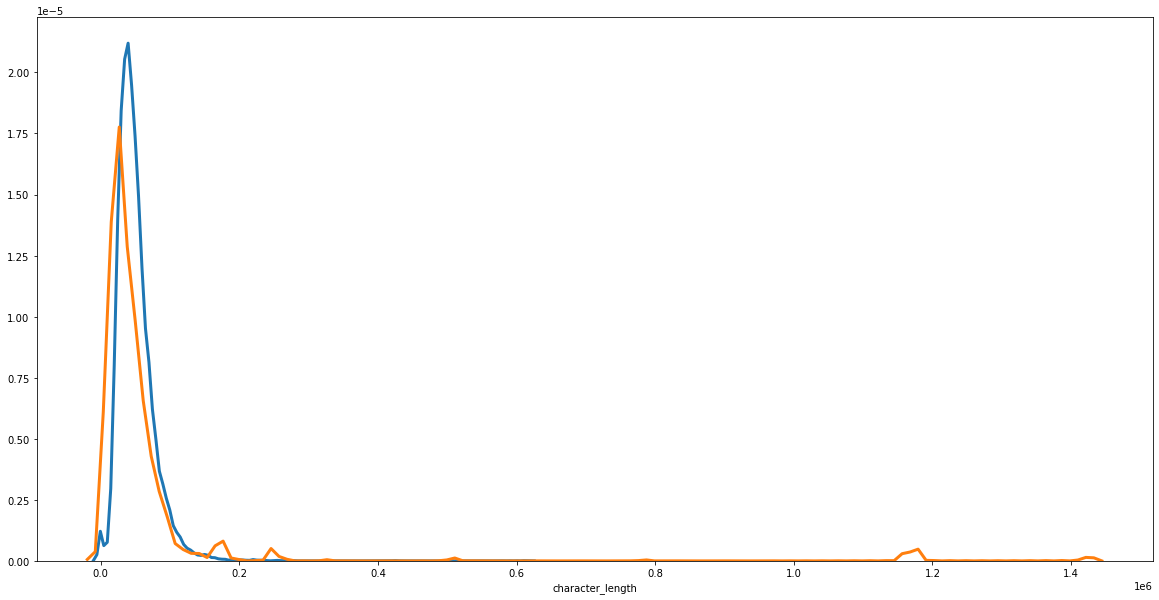

In [50]:
plt.figure(figsize=(20,10))
sns.distplot(no_retract['character_length'], hist=False, kde_kws={"linewidth":3});
sns.distplot(retract['character_length'], hist=False, kde_kws={"linewidth":3});

### Word Count

In [51]:
list_words = []
for i in range(0, len(retract['clean_text'])):
    list_words.append(len(retract['clean_text'][i].split()))
retract['num_words'] = list_words

list_words = []
for i in range(0, len(no_retract['clean_text'])):
    list_words.append(len(no_retract['clean_text'][i].split()))
no_retract['num_words'] = list_words 

In [52]:
retract['num_words'].describe()

count      1537.000000
mean      10076.668185
std       25532.727862
min           6.000000
25%        3042.000000
50%        5152.000000
75%        8917.000000
max      230174.000000
Name: num_words, dtype: float64

In [53]:
no_retract['num_words'].describe()

count     9082.000000
mean      8031.523233
std       4274.592506
min          7.000000
25%       5241.250000
50%       7195.500000
75%       9828.750000
max      95881.000000
Name: num_words, dtype: float64

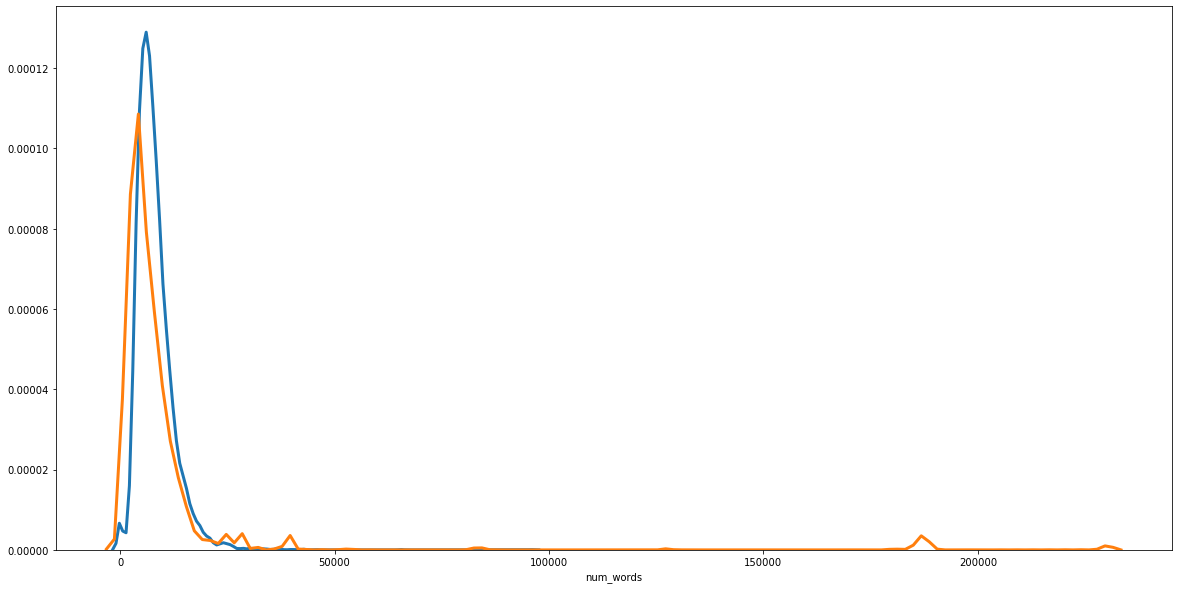

In [54]:
plt.figure(figsize=(20,10))
sns.distplot(no_retract['num_words'], hist=False, kde_kws={"linewidth":3});
sns.distplot(retract['num_words'], hist=False, kde_kws={"linewidth":3});

### Correlation Coefficient Heatmap

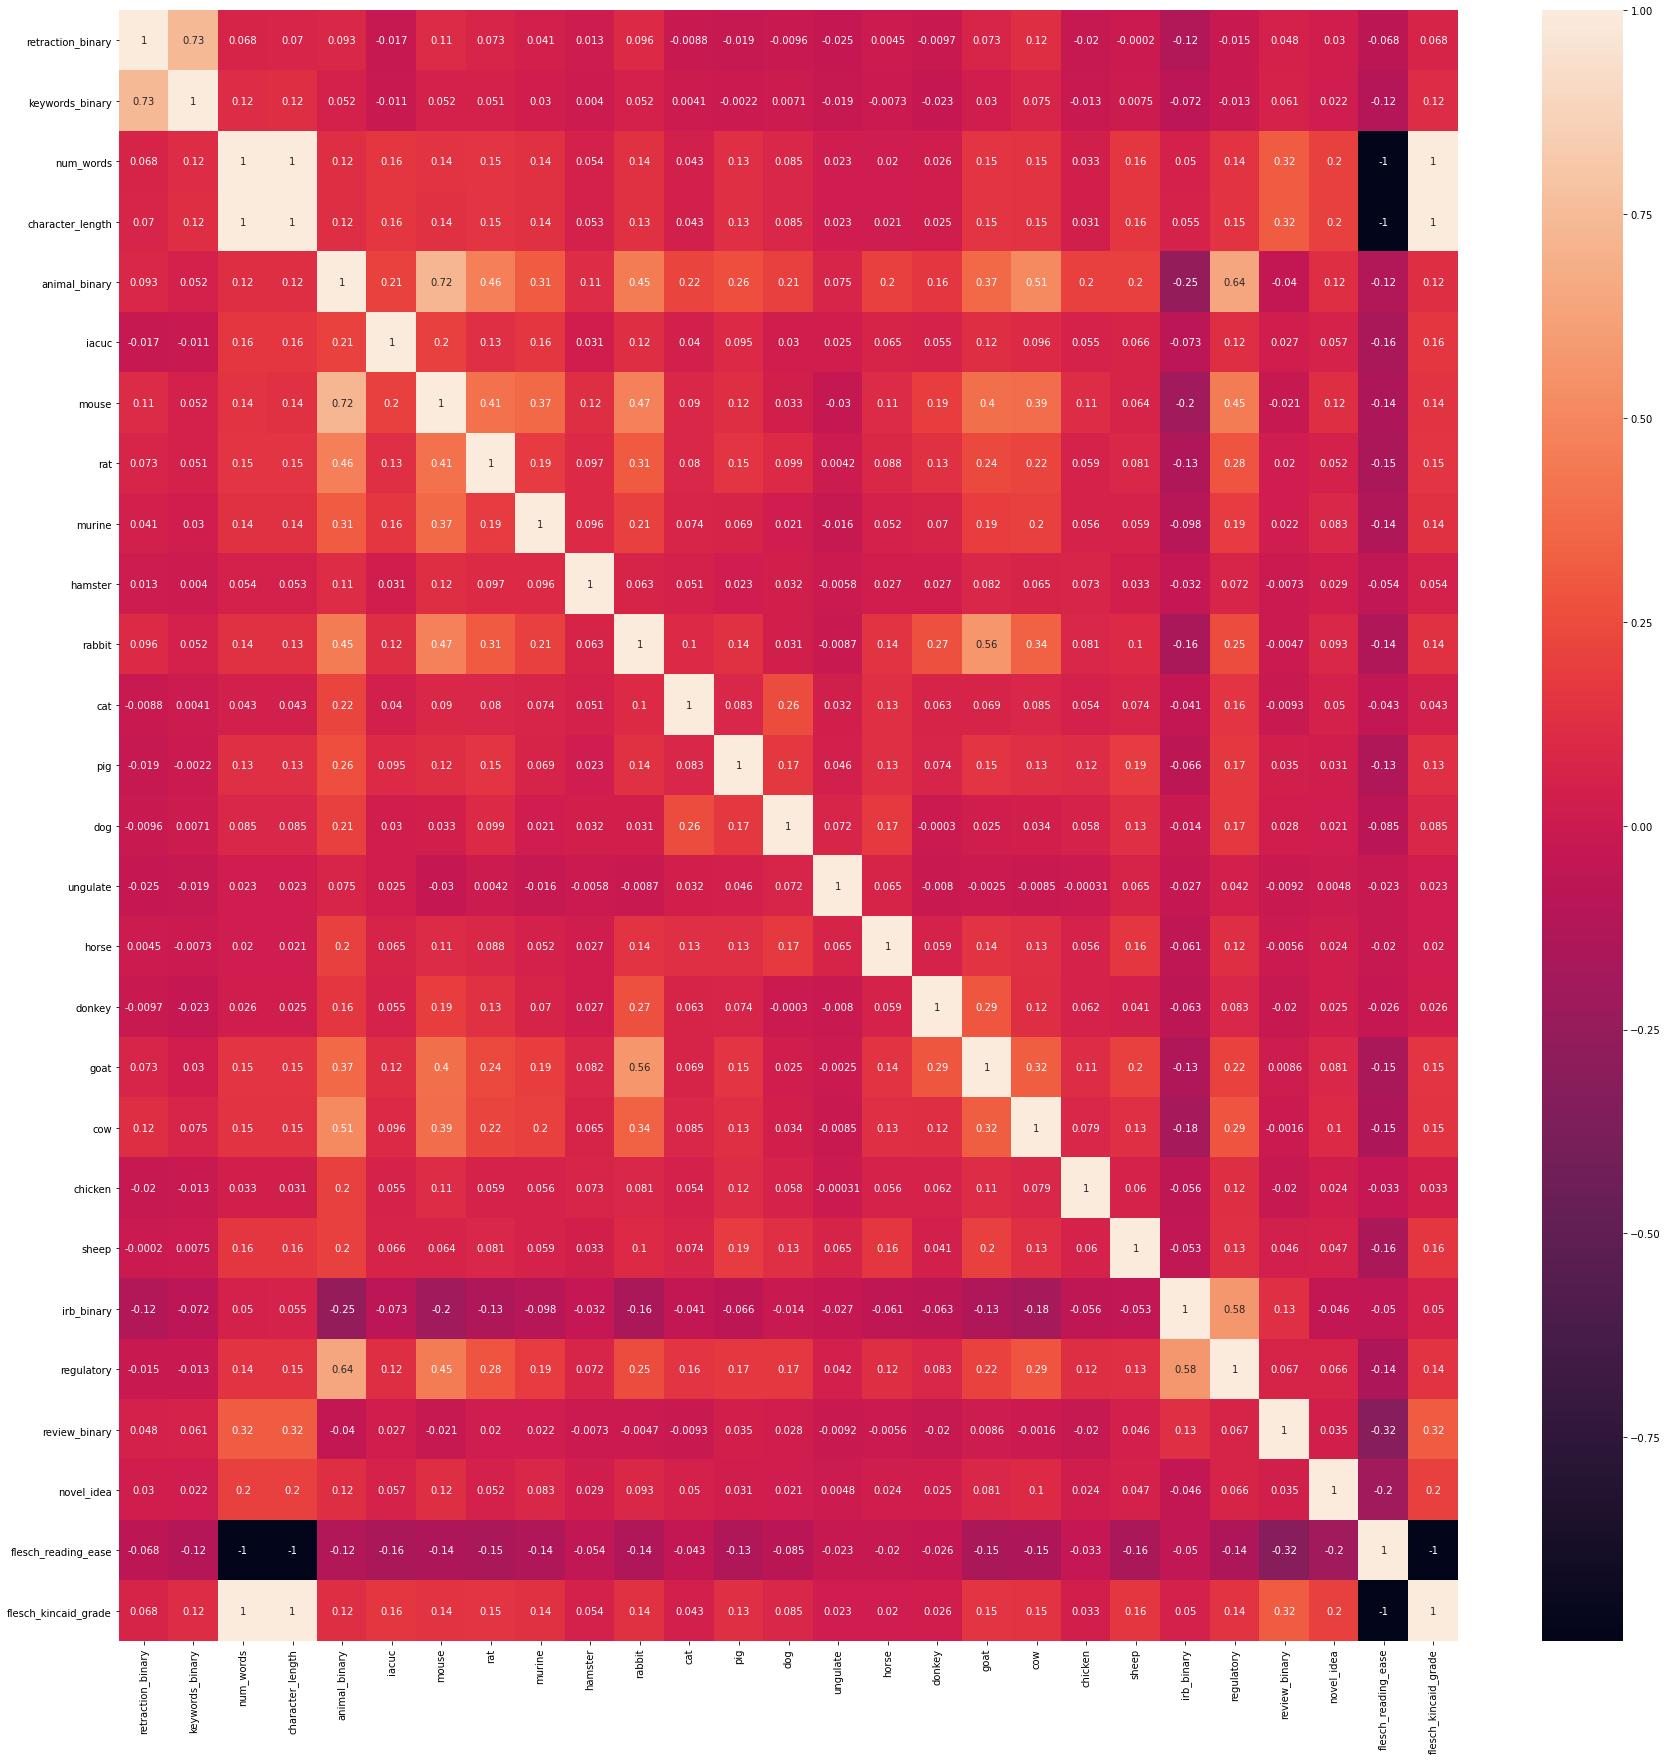

In [55]:
plt.figure(figsize=(30,30))
sns.heatmap(total.corr(), annot=True);

### Keywords Barplots

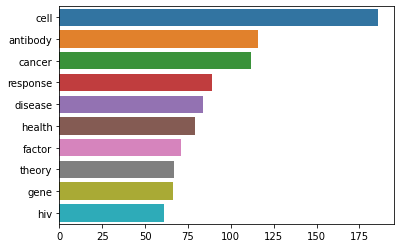

In [56]:
sns.barplot(y=['cell', 'antibody', 'cancer', 'response', 'disease', 'health', 'factor', 'theory', 'gene', 'hiv'],
           x = [186, 116, 112, 89, 84, 79, 71, 67, 66, 61], orient='h');

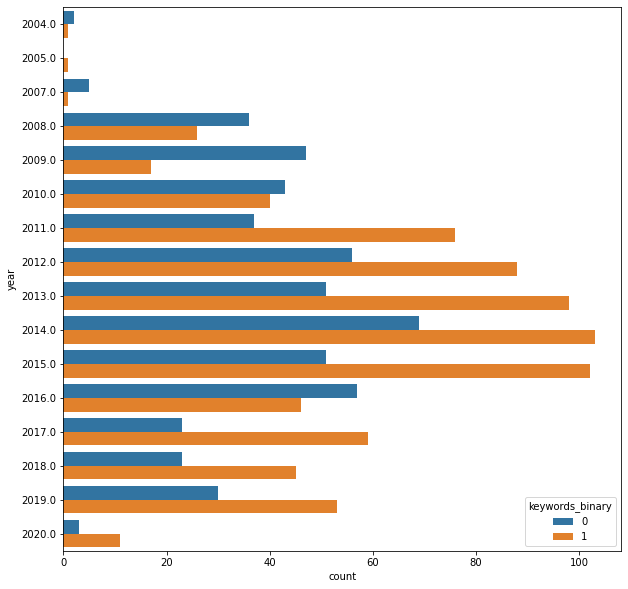

In [57]:
plt.figure(figsize=(10,10))
sns.countplot(y = retract['year'], hue=retract['keywords_binary'], orient = 'h');

In [58]:
retract['keywords'][1230:1459].value_counts()

[]                                                                                                                          50
['Discrimination', 'HIV positive', 'risk behavior', 'VCTC']                                                                  2
['Theme park', 'Attraction management', 'Management effectiveness evaluation']                                               2
['Dairy cattle', 'Milk traits', 'GWAS', 'Closely linked association signals', 'Candidate genes']                             1
['coronary heart disease', 'risk factors', 'diabetes mellitus']                                                              1
                                                                                                                            ..
['Unilateral vocal cord palsy', 'Ishiki type I thyroplasty', 'cervical epidural anaesthesia', 'postoperative analgesia']     1
['bone marrow environment', 'CXCL12/CXCR4', 'oroxylin A', 'Imatinib (IM)', 'β-catenin/P-gp']                   

### Year Barplots

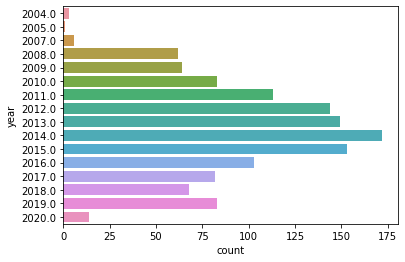

In [59]:
sns.countplot(y= retract['year'], orient='h');

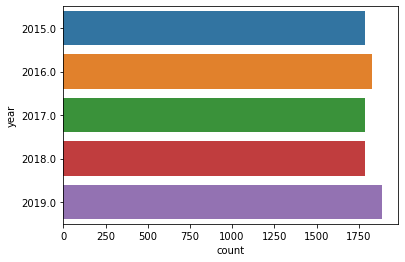

In [60]:
sns.countplot(y =no_retract['year'], orient='h');
#Because of URL set up

### Month Barplots

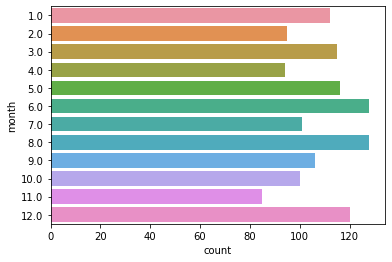

In [61]:
sns.countplot(y=retract['month'], orient='h');

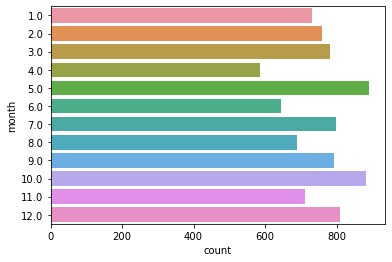

In [62]:
sns.countplot(y=no_retract['month'], orient='h');
#Because of URL set up

### Day Barplots

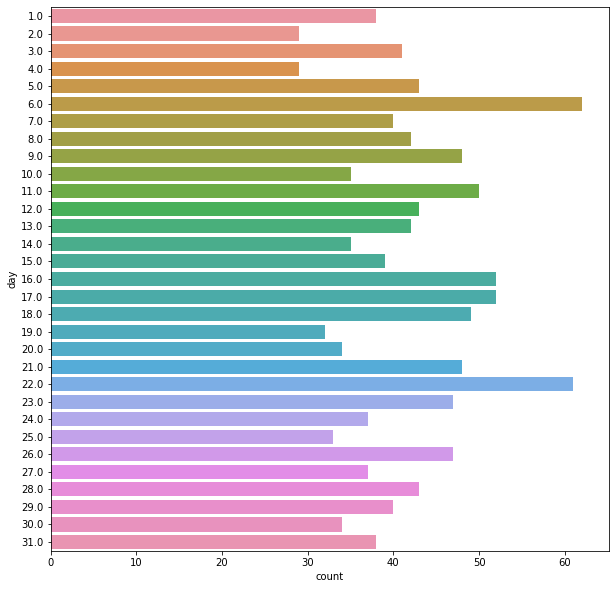

In [63]:
plt.figure(figsize=(10,10))
sns.countplot(y=retract['day'], orient='h');

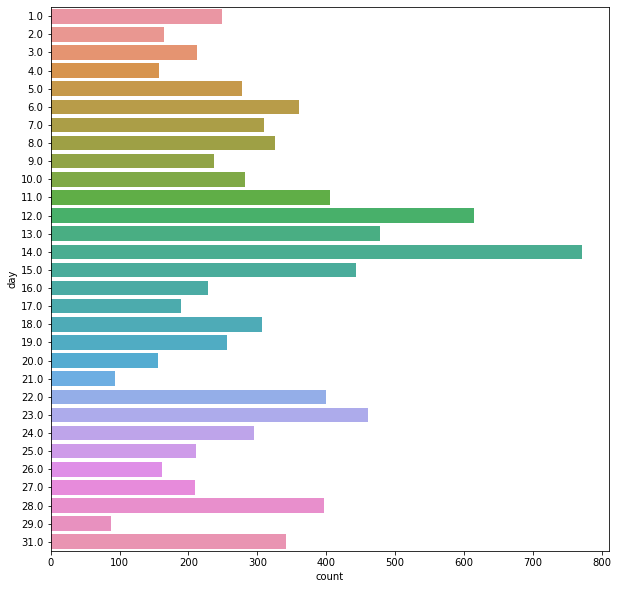

In [64]:
plt.figure(figsize=(10,10))
sns.countplot(y=no_retract['day'], orient='h');

### Volume Barplots

In [65]:
retract['volume'].value_counts().head(11)

9.0      105
7.0      103
8.0       89
10.0      77
5.0       58
11.0      56
12.0      51
6.0       50
3.0       43
4.0       33
286.0     30
Name: volume, dtype: int64

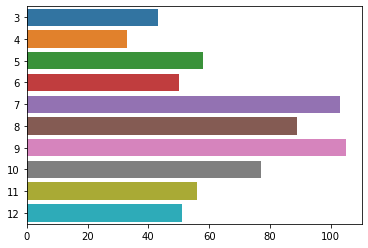

In [66]:
sns.barplot(y=[9, 7, 8, 10, 5, 11, 12, 6, 3, 4],
           x = [105, 103, 89, 77, 58, 56, 51, 50, 43, 33], orient='h');

In [67]:
no_retract['volume'].value_counts().head(11)
#because of URL set up

14.0    1889
11.0    1830
10.0    1790
13.0    1787
12.0    1786
Name: volume, dtype: int64

### Issue Barplots

In [68]:
retract['issue'].value_counts().head(12)

1.0     173
3.0      89
4.0      86
2.0      84
6.0      79
5.0      77
7.0      47
8.0      45
10.0     41
12.0     40
11.0     31
9.0      30
Name: issue, dtype: int64

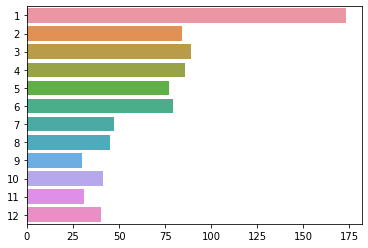

In [69]:
sns.barplot(y=[1, 3, 4, 2, 6, 5, 7, 8, 10, 12, 11, 9],
           x = [173, 89, 86, 84, 79, 77, 47, 45, 41, 40, 31, 30], orient='h');

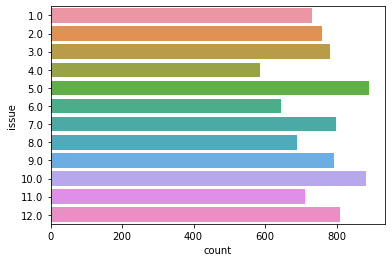

In [70]:
sns.countplot(y=no_retract['issue'], orient='h');

### Animal Studies

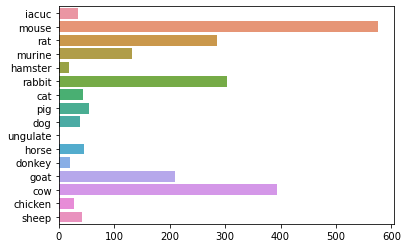

In [71]:
sns.barplot(y = ['iacuc', 'mouse', 'rat', 'murine', 'hamster', 'rabbit', 'cat', 'pig', 'dog', 'ungulate', 
                 'horse', 'donkey', 'goat', 'cow', 'chicken', 'sheep'], 
            x = [sum(retract['iacuc']), sum(retract['mouse']), sum(retract['rat']), sum(retract['murine']), 
                sum(retract['hamster']), sum(retract['rabbit']), sum(retract['cat']), sum(retract['pig']), sum(retract['dog']), 
                sum(retract['ungulate']), sum(retract['horse']), sum(retract['donkey']), sum(retract['goat']), 
                sum(retract['cow']), sum(retract['chicken']), sum(retract['sheep'])], orient = 'h');

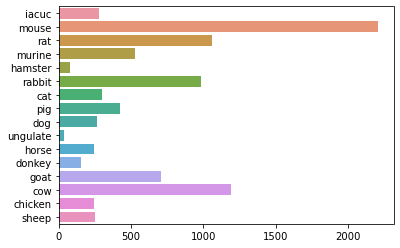

In [72]:
sns.barplot(y = ['iacuc', 'mouse', 'rat', 'murine', 'hamster', 'rabbit', 'cat', 'pig', 'dog', 'ungulate', 
                 'horse', 'donkey', 'goat', 'cow', 'chicken', 'sheep'], 
            x = [sum(no_retract['iacuc']), sum(no_retract['mouse']), sum(no_retract['rat']), 
                 sum(no_retract['murine']), sum(no_retract['hamster']), sum(no_retract['rabbit']), 
                 sum(no_retract['cat']), sum(no_retract['pig']), sum(no_retract['dog']), 
                sum(no_retract['ungulate']), sum(no_retract['horse']), sum(no_retract['donkey']), 
                 sum(no_retract['goat']), sum(no_retract['cow']), sum(no_retract['chicken']), 
                 sum(no_retract['sheep'])], orient = 'h');

### Journal Barplot for Retraction Data

In [73]:
retract['journal'].value_counts().head(10)

PloS one                                                                              229
The Journal of biological chemistry                                                   169
Diagnostic pathology                                                                   30
Acta crystallographica. Section E, Structure reports online                            28
Medicine                                                                               24
OncoTargets and therapy                                                                23
BioMed research international                                                          22
The Journal of neuroscience : the official journal of the Society for Neuroscience     19
European journal of medical research                                                   18
Evidence-based complementary and alternative medicine : eCAM                           15
Name: journal, dtype: int64

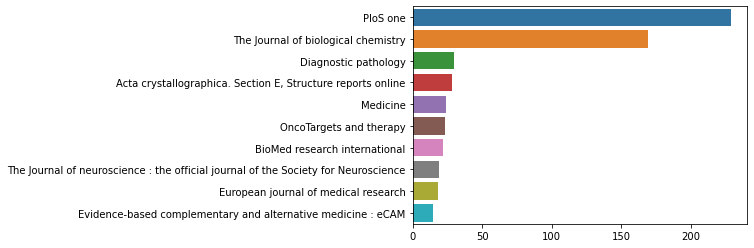

In [74]:
sns.barplot(y=['PloS one', 'The Journal of biological chemistry',
              'Diagnostic pathology', 'Acta crystallographica. Section E, Structure reports online',
              'Medicine', 'OncoTargets and therapy', 'BioMed research international',
              'The Journal of neuroscience : the official journal of the Society for Neuroscience',
              'European journal of medical research', 'Evidence-based complementary and alternative medicine : eCAM'],
           x = [229, 169, 30, 28, 24, 23, 22, 19, 18, 15], orient='h');

### Text Readability

In [75]:
retract['flesch_reading_ease'].describe()

count      1537.000000
mean     -10163.970345
std       25915.387264
min     -233563.600000
25%       -8985.040000
50%       -5166.270000
75%       -3024.620000
max          81.290000
Name: flesch_reading_ease, dtype: float64

In [76]:
no_retract['flesch_reading_ease'].describe()

count     9082.000000
mean     -8087.809740
std       4337.544257
min     -97256.210000
25%      -9916.220000
50%      -7240.930000
75%      -5256.695000
max         64.370000
Name: flesch_reading_ease, dtype: float64

In [77]:
retract['flesch_kincaid_grade'].describe()

count     1537.000000
mean      3934.081132
std       9957.707227
min          3.700000
25%       1190.900000
50%       2013.800000
75%       3480.900000
max      89772.300000
Name: flesch_kincaid_grade, dtype: float64

In [78]:
no_retract['flesch_kincaid_grade'].describe()

count     9082.000000
mean      3136.599736
std       1666.924692
min          6.000000
25%       2048.825000
50%       2810.700000
75%       3838.500000
max      37398.100000
Name: flesch_kincaid_grade, dtype: float64

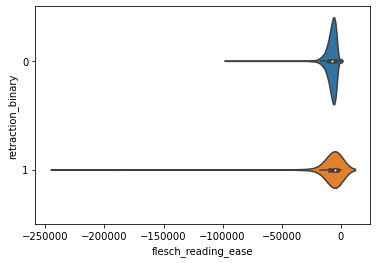

In [79]:
sns.violinplot(x = total['flesch_reading_ease'], y = total['retraction_binary'], orient='h');

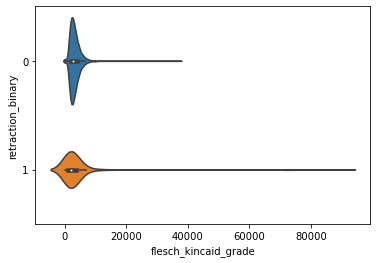

In [80]:
sns.violinplot(x = total['flesch_kincaid_grade'], y = total['retraction_binary'], orient='h');